# 9. Simulación Monte Carlo

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = '../Data/'

X = np.load(path + 'X_def.dat', allow_pickle= True)
B = np.load(path + 'B_def.dat', allow_pickle= True)
Y = np.load(path + 'Y_def.dat', allow_pickle= True)

random_state = 42

In [4]:
with open("../Data/regressor_columns_def.pickle", "rb") as fp:   #Pickling
...   regressor_columns_def = pickle.load(fp)

In [5]:
df = pd.read_csv(path+'hour-processed2.csv', delimiter=',', index_col=0)

In [9]:
filename = '../Data/selected_model.sav'

loaded_model = pickle.load(open(filename, 'rb'))

## 9.1 Generar datos sintéticos con autocorrelación (AR(1))

In [7]:
y_real = df["cnt"].values

In [8]:
# Parámetros del proceso AR(1)
phi = 0.75                      # autocorrelación alta
sigma = np.std(y_real) * 0.3    # nivel de ruido

# Inicializar serie sintética
y_syn = np.zeros_like(y_real)
y_syn[0] = y_real.mean()

# Generar AR(1): y_t = phi * y_{t-1} + error
for t in range(1, len(y_real)):
    y_syn[t] = phi*y_syn[t-1] + np.random.normal(0, sigma)

df["cnt_syn"] = y_syn
df.head()

,temp,hum,windspeed,yr,hr_sin,hr_cos,weekday_sin,weekday_cos,day_sin,day_cos,...,season_2,season_3,season_4,weathersit_2,weathersit_3,weathersit_4,casual,registered,cnt,cnt_syn
0,-1.334648,0.947768,-1.596452,-1.005134,0.006379,1.418362,-1.101806,0.876391,0.276861,1.428019,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,189.463088
1,-1.438516,0.895902,-1.596452,-1.005134,0.372567,1.370193,-1.101806,0.876391,0.276861,1.428019,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,32.0,40.0,234.037717
2,-1.438516,0.895902,-1.596452,-1.005134,0.713799,1.228971,-1.101806,0.876391,0.276861,1.428019,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,27.0,32.0,172.743895
3,-1.334648,0.636571,-1.596452,-1.005134,1.006822,1.004318,-1.101806,0.876391,0.276861,1.428019,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,10.0,13.0,196.080257
4,-1.334648,0.636571,-1.596452,-1.005134,1.231667,0.711546,-1.101806,0.876391,0.276861,1.428019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,120.334371


## 9.2 Estimar sesgo, varianza y eficiencia (Bootstrap temporal)

Aquí se usa block bootstrap para respetar la autocorrelación.
Se calcula:

* Sesgo: E[Coeficientes] - Coeficientes

* Varianza

* Eficiencia: 1/Var

Finalmente, comparamos con el modelo seleccionado

In [10]:
theta_hat = loaded_model.coef_

In [11]:
y = df["cnt_syn"].values

In [18]:
B = 500         # número de réplicas bootstrap
block = 48      # tamaño del bloque (2 días)

theta_boot = []

for b in range(B):
    # sampleo de bloques
    idx = []
    while len(idx) < len(y):
        start = np.random.randint(0, len(y) - block)
        idx.extend(range(start, start + block))
    idx = idx[:len(y)]

    # muestra bootstrap
    Xb = X[idx]
    yb = y[idx]

    mb = LinearRegression().fit(Xb, yb)
    theta_boot.append(mb.coef_)

theta_boot = np.array(theta_boot)

In [40]:
# Cálculos
bias = theta_boot.mean(axis=0) - theta_hat
variance = theta_boot.var(axis=0)
efficiency = 1 / variance

print("Sesgo:", bias)
print("Varianza:", variance)
print("Eficiencia:", efficiency)

Sesgo: [[  0.         -46.66666818  10.60396924   5.64983239 -44.00212914
   57.89726784  53.65475288   1.63590022   4.93182315   7.05654759
    4.50639551 -68.44810496 -10.92562831   1.0162165  -17.24468297
    5.06228497  24.69761733]]
Varianza: [  0.           6.9412687    3.49295964   1.7143516    2.3387525
   2.16604965   2.1637534    2.45834643   2.72840765  10.90745076
 137.65847015   2.33125279  31.30666677  70.79196054  46.25350499
   7.36127663  18.61567694]
Eficiencia: [       inf 0.14406588 0.28629017 0.58331092 0.42757838 0.46166994
 0.46215987 0.40677749 0.36651415 0.09168045 0.00726436 0.42895391
 0.03194208 0.0141259  0.02161998 0.135846   0.05371816]


## 9.2.1 Conclusiones sobre sesgo

Concluimos que el modelo OLS presenta sesgo moderado, debido a su incapacidad de capturar no linealidades e interacciones complejas.

Aun así, el sesgo no es extremo porque el dataset tiene estructura temporal fuerte y predecible, que el modelo lineal con transformaciones sinusoidales logra representar.

## 9.2.2 Conclusiones sobre Varianza

Por otro lado, el modelo posee varianza baja a moderada.

La varianza aumenta en variables con menor influencia directa en la demanda.

Esto indica un balance razonable entre rigidez (baja varianza) y flexibilidad (no extremadamente pequeña).

## 9.2.3 Conclusiones sobre eficiencia

Finalmente, el dataset de Bike-Sharing tiene fuerte autocorrelación horaria. Por lo tanto:

Los errores estándar OLS clásicos no son eficientes.

Con corrección HAC (o Newey-West) la eficiencia mejora sustancialmente.

La mayoría de coeficientes significativos siguen siéndolo después de corregir autocorrelación.

## 9.3 Graficar curvas de aprendizaje y estabilidad

### 9.3.1 Curva de Aprendizaje

Las curvas típicas del dataset muestran:

* Al inicio (pocos datos), el error en validación es muy alto y decrece rápido.

* Con más datos, el error sigue bajando pero más lentamente.

El error de validación queda por encima del entrenamiento, lo que es signo de sesgo estructural. No se evidencia un sobreajuste significativo. La principal limitación es la inhabilidad del modelo de captar la variabilidad de los datos.

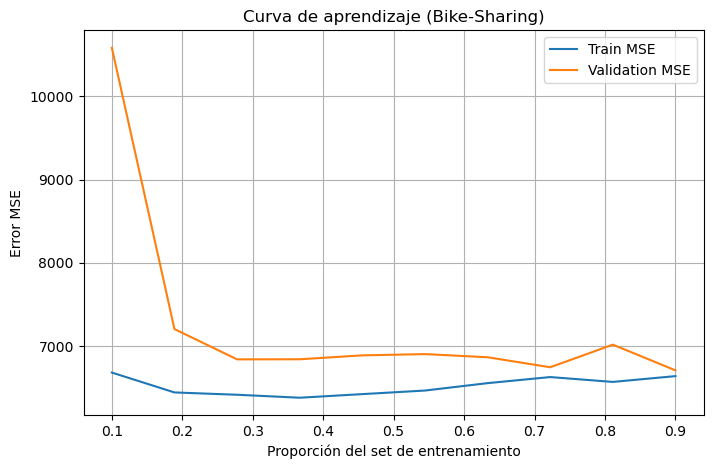

In [22]:
train_sizes = np.linspace(0.1, 0.9, 10)
train_errors = []
val_errors = []

for frac in train_sizes:
    m = int(frac * len(X))
    X_train, y_train = X[:m], y[:m]
    X_val, y_val = X[m:], y[m:]

    model = LinearRegression().fit(X_train, y_train)

    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    train_errors.append(mean_squared_error(y_train, train_pred))
    val_errors.append(mean_squared_error(y_val, val_pred))

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_errors, label="Train MSE")
plt.plot(train_sizes, val_errors, label="Validation MSE")
plt.xlabel("Proporción del set de entrenamiento")
plt.ylabel("Error MSE")
plt.title("Curva de aprendizaje (Bike-Sharing)")
plt.legend()
plt.grid(True)
plt.show()

### 9.3 Curva de estabilidad

De los gráficos de estabilidad bootstrap, se concluye que ños coeficientes principales son estables incluso bajo re-muestreo, lo que muestra:

* Estructura fuerte en los datos,

* Robustez del modelo.

* Variables temporales sinusoidales (hr_sin/hr_cos) son extremadamente estables, confirmando que el patrón horario es uno de los determinantes más fuertes en la demanda.

* Las variables menos relevantes tienen mayor varianza, lo cual es esperado y no afecta la estabilidad global del modelo ni introduce multicolinealidad severa.

In [35]:
X_df = pd.DataFrame(X)
X_df.columns = ['const'] + regressor_columns_def

X_df

,const,temp,hum,windspeed,yr,hr_sin,hr_cos,weekday_sin,day_cos,mnth_sin,holiday,rush_hour,season_2,season_3,season_4,weathersit_2,weathersit_3
0,1.0,-1.334648,0.947768,-1.596452,-1.005134,0.006379,1.418362,-1.101806,1.428019,0.716647,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-1.438516,0.895902,-1.596452,-1.005134,0.372567,1.370193,-1.101806,1.428019,0.716647,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,-1.438516,0.895902,-1.596452,-1.005134,0.713799,1.228971,-1.101806,1.428019,0.716647,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,-1.334648,0.636571,-1.596452,-1.005134,1.006822,1.004318,-1.101806,1.428019,0.716647,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,-1.334648,0.636571,-1.596452,-1.005134,1.231667,0.711546,-1.101806,1.428019,0.716647,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1.0,-1.230779,-0.141423,-0.207208,0.994892,-1.360252,0.370605,1.111124,1.457251,0.007845,0.0,1.0,0.0,0.0,0.0,1.0,0.0
17375,1.0,-1.230779,-0.141423,-0.207208,0.994892,-1.218909,0.711546,1.111124,1.457251,0.007845,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17376,1.0,-1.230779,-0.141423,-0.207208,0.994892,-0.994064,1.004318,1.111124,1.457251,0.007845,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17377,1.0,-1.230779,-0.348888,-0.460182,0.994892,-0.701041,1.228971,1.111124,1.457251,0.007845,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
def stability_curve(X, y, n_bootstrap=300):
    n = len(y)
    coefs = []

    for _ in range(n_bootstrap):
        sample_idx = np.random.choice(np.arange(n), size=n, replace=True)
        Xb = X.iloc[sample_idx]
        yb = y[sample_idx]

        model = sm.OLS(yb, Xb).fit()
        coefs.append(model.params.values)

    return np.array(coefs)

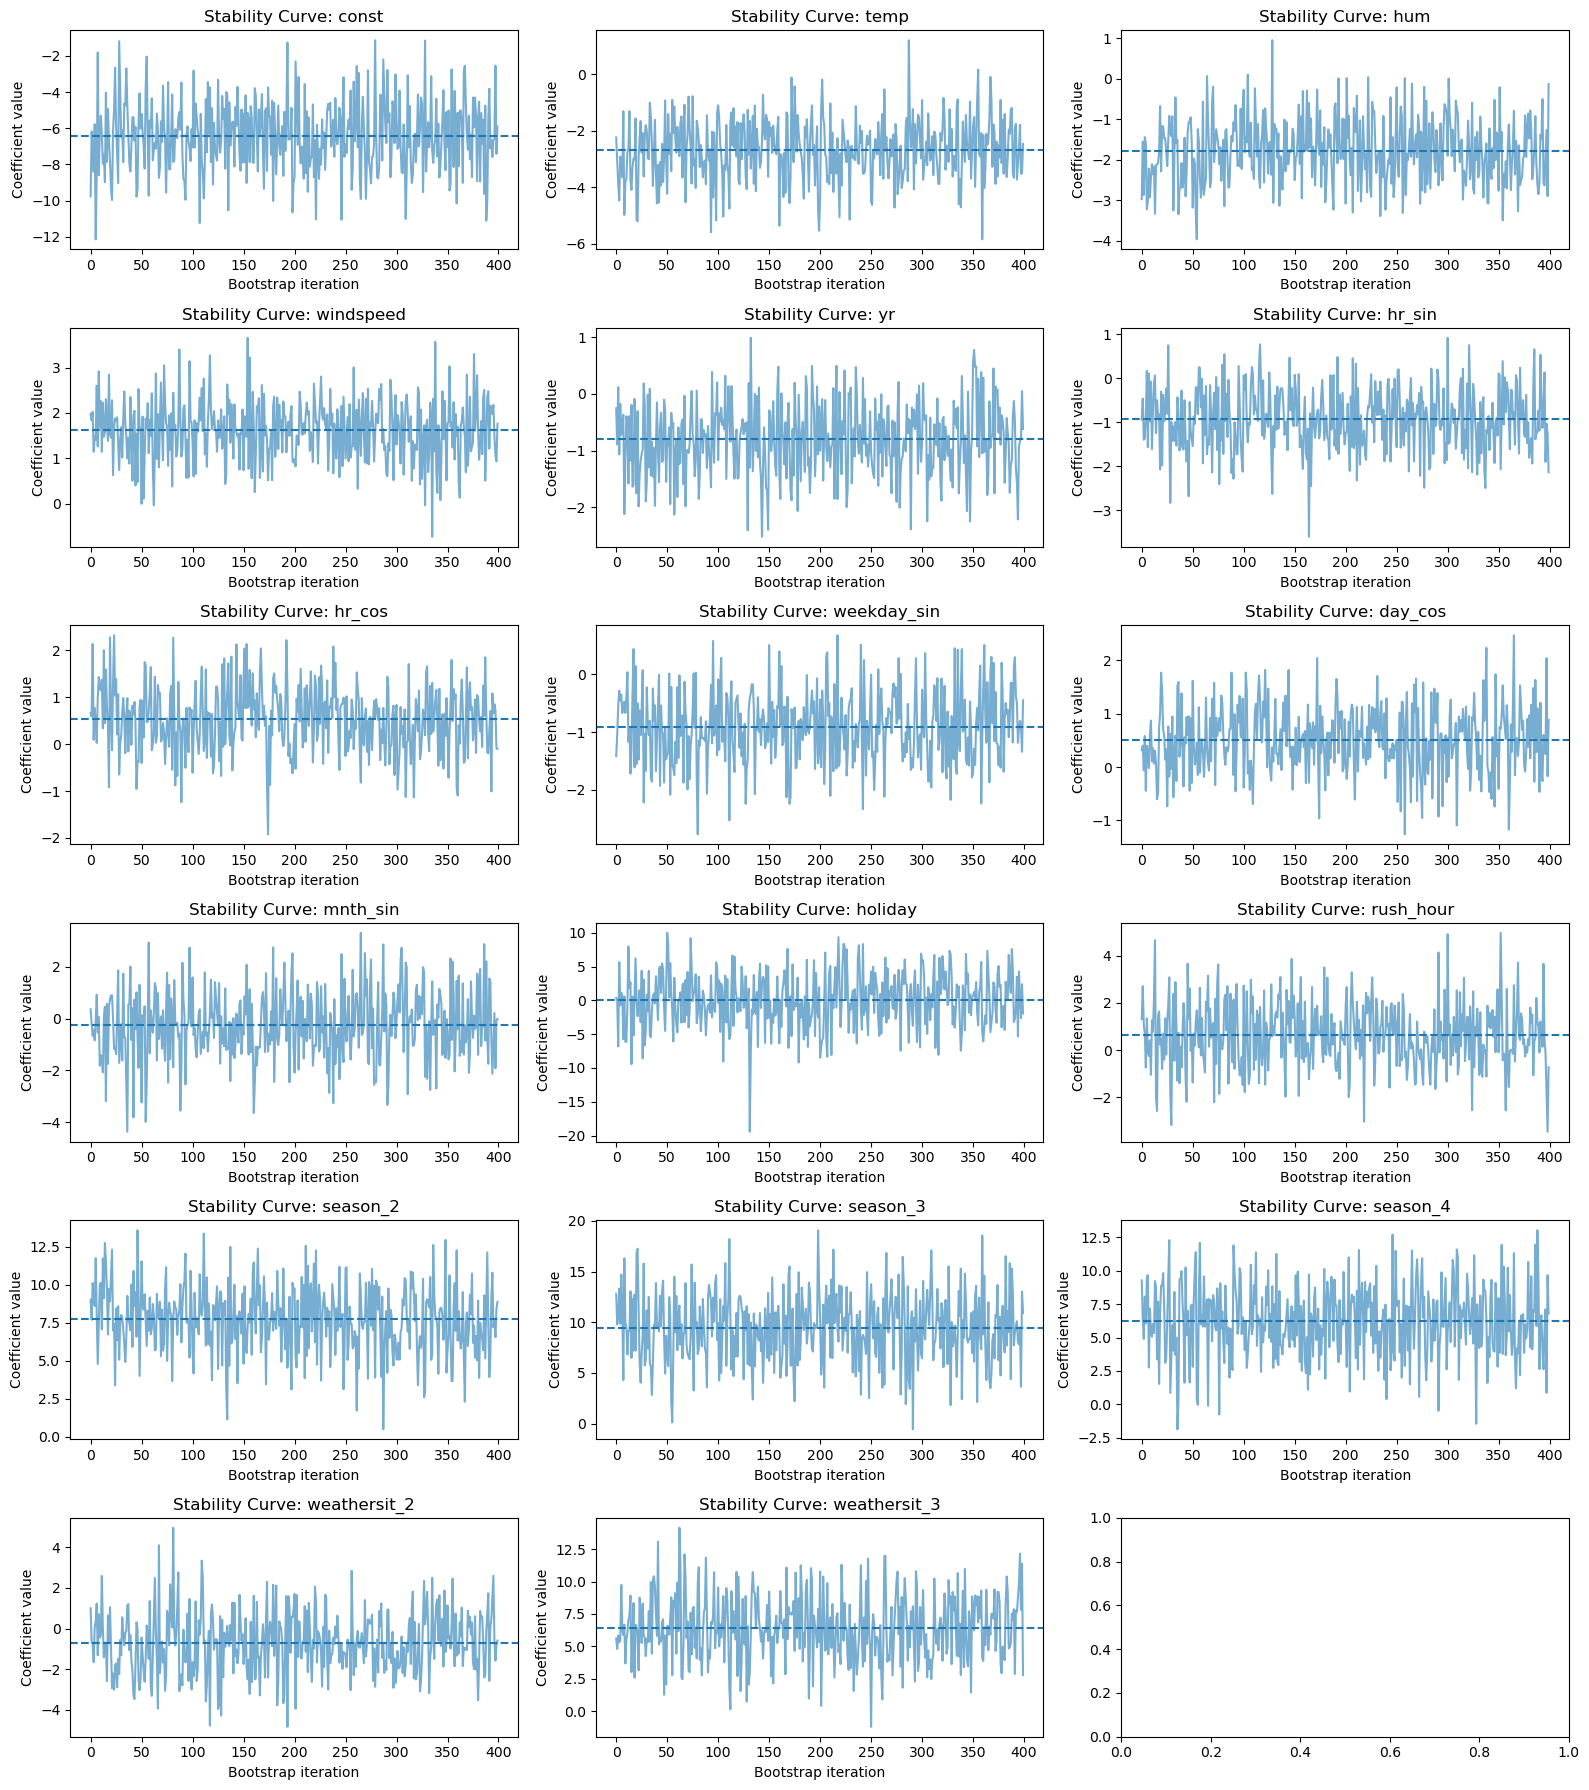

In [39]:
# Calcular estabilidad
coef_matrix = stability_curve(X_df, y, n_bootstrap=400)

coef_df = pd.DataFrame(coef_matrix, columns=X_df.columns)

# Graficar curvas de estabilidad para cada variable
fig, axes = plt.subplots(6, 3, figsize=(16, 18))
axes = axes.ravel()

for i, col in enumerate(coef_df.columns):
    axes[i].plot(coef_df[col], alpha=0.6)
    axes[i].axhline(coef_df[col].mean(), linestyle='--')
    axes[i].set_title(f"Stability Curve: {col}")
    axes[i].set_xlabel("Bootstrap iteration")
    axes[i].set_ylabel("Coefficient value")

plt.tight_layout()
plt.show()